In [34]:
# --- CELL 1: Data Loading with Z-Score (Fix for Low F1) ---
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter

# Config
INPUT_ROOT = "/kaggle/input"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def normalize_zscore(a):
    """
    Z-Score Normalization (Mean=0, Std=1).
    Better for Anomaly Detection because it preserves the MAGNITUDE of outliers.
    """
    mu = np.mean(a, axis=0)
    std = np.std(a, axis=0)
    # Avoid division by zero
    return (a - mu) / (std + 1e-6)

class SMAP_Clean_Dataset(Dataset):
    def __init__(self, file_paths, window_size=100, mode='train'):
        self.window_size = window_size
        self.mode = mode
        self.windows = []
        
        print(f"   Processing {len(file_paths)} {mode} files...")
        
        for fp in file_paths:
            try:
                arr = np.load(fp)
                if len(arr.shape) == 1: arr = arr.reshape(-1, 1)
                if len(arr) < window_size: continue
                
                # USE Z-SCORE HERE
                arr = normalize_zscore(arr)
                
                stride = 10
                num_wins = (len(arr) - window_size) // stride + 1
                if num_wins > 0:
                    idx = np.arange(window_size)[None, :] + np.arange(num_wins)[:, None] * stride
                    self.windows.append(arr[idx])
            except: pass
                
        if self.windows:
            self.windows = np.concatenate(self.windows, axis=0)
        else:
            self.windows = np.array([])
            
        print(f"[{mode.upper()}] Final Dataset Shape: {self.windows.shape}")

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        if self.mode == 'train':
            v1 = self.geometric_mask(window)
            v2 = self.geometric_mask(window)
            return torch.FloatTensor(v1), torch.FloatTensor(v2), torch.FloatTensor(window)
        else:
            return torch.FloatTensor(window)

    def geometric_mask(self, window):
        w = window.copy()
        L, D = w.shape
        if np.random.rand() < 0.5: 
            t_len = max(1, int(L * 0.1))
            t_start = np.random.randint(0, L - t_len)
            f_len = max(1, int(D * 0.2))
            f_start = np.random.randint(0, D - f_len)
            w[t_start:t_start+t_len, f_start:f_start+f_len] = 0.0
        return w

def get_clean_loaders(batch_size=64):
    print("Scanning Data...")
    all_files = []
    dims = []
    
    # Scan files
    for root, dirs, files in os.walk(INPUT_ROOT):
        for f in sorted(files):
            if f.endswith('.npy') and 'label' not in f:
                path = os.path.join(root, f)
                try:
                    s = np.load(path).shape
                    if len(s) > 1 and s[1] > 1:
                        dims.append(s[1])
                        all_files.append((path, s[1]))
                except: pass
    
    if not dims: return None, None, 0
    
    common_dim = Counter(dims).most_common(1)[0][0]
    train_files = [p for (p, d) in all_files if d == common_dim and 'train' in p.lower()]
    test_files = [p for (p, d) in all_files if d == common_dim and 'test' in p.lower()]
    
    # Fallback if names don't match
    if not train_files:
        valid = [p for (p, d) in all_files if d == common_dim]
        split = int(len(valid)*0.8)
        train_files = valid[:split]
        test_files = valid[split:]

    print(f"Selected Dimension: {common_dim}. Train: {len(train_files)}, Test: {len(test_files)}")
    
    train_ds = SMAP_Clean_Dataset(train_files, mode='train')
    test_ds = SMAP_Clean_Dataset(test_files, mode='test')
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, common_dim, test_files

train_loader, test_loader, feat_dim, test_files = get_clean_loaders()

Scanning Data...
Selected Dimension: 25. Train: 54, Test: 54
   Processing 54 train files...
[TRAIN] Final Dataset Shape: (13299, 100, 25)
   Processing 54 test files...
[TEST] Final Dataset Shape: (43076, 100, 25)


In [ ]:
# --- CELL 1: Smart Data Loading (Debug Mode) ---
'''
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter



# Config
INPUT_ROOT = "/kaggle/input"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def normalize3(a):
    """Min-Max Normalization (0-1 range)."""
    min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    denom = max_a - min_a
    denom[denom == 0] = 1.0 
    return (a - min_a) / denom

class SMAP_Clean_Dataset(Dataset):
    def __init__(self, file_paths, window_size=100, mode='train'):
        self.window_size = window_size
        self.mode = mode
        self.windows = []
        
        print(f"   Processing {len(file_paths)} {mode} files...")
        
        for fp in file_paths:
            try:
                arr = np.load(fp)
                if len(arr.shape) == 1: arr = arr.reshape(-1, 1)
                
                # Check Length
                if len(arr) < window_size: continue
                
                # Normalize
                arr = normalize3(arr)
                
                # Slice into Windows
                stride = 10
                num_wins = (len(arr) - window_size) // stride + 1
                
                if num_wins > 0:
                    idx = np.arange(window_size)[None, :] + np.arange(num_wins)[:, None] * stride
                    self.windows.append(arr[idx])
            except Exception as e:
                pass
                
        # Concatenate
        if self.windows:
            self.windows = np.concatenate(self.windows, axis=0)
        else:
            self.windows = np.array([])
            
        print(f"[{mode.upper()}] Final Dataset Shape: {self.windows.shape}")

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        if self.mode == 'train':
            v1 = self.geometric_mask(window)
            v2 = self.geometric_mask(window)
            return torch.FloatTensor(v1), torch.FloatTensor(v2), torch.FloatTensor(window)
        else:
            return torch.FloatTensor(window)

    def geometric_mask(self, window):
        w = window.copy()
        L, D = w.shape
        if np.random.rand() < 0.5: 
            t_len = max(1, int(L * 0.1))
            t_start = np.random.randint(0, L - t_len)
            f_len = max(1, int(D * 0.2))
            f_start = np.random.randint(0, D - f_len)
            w[t_start:t_start+t_len, f_start:f_start+f_len] = 0.0
        return w

def get_clean_loaders(batch_size=64):
    print("DIAGNOSTIC SCAN (Looking for sensor data)...")
    all_files = []
    dims = []
    
    for root, dirs, files in os.walk(INPUT_ROOT):
        for f in sorted(files):
            if f.endswith('.npy') and 'label' not in f:
                path = os.path.join(root, f)
                try:
                    # Load minimal part to check shape
                    # We can't partial load .npy easily, so we full load (fast on Kaggle)
                    arr = np.load(path)
                    s = arr.shape
                    
                    # IGNORE 1D files (Labels/Metadata)
                    if len(s) > 1 and s[1] > 1:
                        d = s[1]
                        all_files.append((path, d))
                        dims.append(d)
                except: pass
    
    # REPORT
    if not dims:
        print("CRITICAL: No >1D .npy files found.")
        print("   Are you sure the dataset is attached?")
        return None, None, 0
    
    dim_counts = Counter(dims)
    print(f"Found Dimensions: {dict(dim_counts)}")
    
    # 2. Pick most common valid dimension
    common_dim = dim_counts.most_common(1)[0][0]
    print(f"Selected Target Dimension: {common_dim} features")
    
    # 3. Filter Files
    # Robust logic: look for 'train' string, OR assume large folder separation
    train_files = []
    test_files = []
    
    for (p, d) in all_files:
        if d == common_dim:
            if 'train' in p.lower():
                train_files.append(p)
            elif 'test' in p.lower():
                test_files.append(p)
            else:
                # Fallback: Check parent folder structure if names are obscure
                # Assuming standard Telemanom structure usually splits by folder
                pass

    print(f"   Selected: {len(train_files)} Train files, {len(test_files)} Test files.")
    
    if len(train_files) == 0:
        print("Warning: No files with 'train' in path found. Trying to split manually...")
        # Emergency Split (80/20) if folder structure is lost
        valid_files = [p for (p,d) in all_files if d == common_dim]
        split = int(len(valid_files) * 0.8)
        train_files = valid_files[:split]
        test_files = valid_files[split:]
        print(f"   Manual Split: {len(train_files)} Train, {len(test_files)} Test")

    # 4. Create Datasets
    train_ds = SMAP_Clean_Dataset(train_files, mode='train')
    test_ds = SMAP_Clean_Dataset(test_files, mode='test')
    
    if len(train_ds) == 0:
        print("Error: Dataset empty. Files might be too short.")
        return None, None, 0
        
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, common_dim

# Run Data Prep
train_loader, test_loader, feat_dim = get_clean_loaders()
'''

In [35]:
# --- CELL 2: Models ---
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :]

class TransformerGAN(nn.Module):
    def __init__(self, feat_dim, d_model=128):
        super().__init__()
        self.input_proj = nn.Linear(feat_dim, d_model)
        self.pos = PositionalEncoding(d_model)
        
        # Encoder-Decoder Transformer
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead=4, dim_feedforward=256, batch_first=True), num_layers=2)
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead=4, dim_feedforward=256, batch_first=True), num_layers=2)
        
        self.output_proj = nn.Linear(d_model, feat_dim)
        self.d_model = d_model

    def forward(self, x):
        src = self.pos(self.input_proj(x) * math.sqrt(self.d_model))
        z = self.encoder(src)
        # Use source as target query for reconstruction
        out = self.decoder(src, z) 
        return self.output_proj(out), z.mean(dim=1)

class Discriminator(nn.Module):
    def __init__(self, feat_dim, win_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim * win_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

Starting Full Framework Training...
Epoch 1/50: Loss G=0.8149 | Loss D=1.1420
Epoch 2/50: Loss G=0.5018 | Loss D=0.9346
Epoch 3/50: Loss G=0.4149 | Loss D=0.8581
Epoch 4/50: Loss G=0.3629 | Loss D=0.9137
Epoch 5/50: Loss G=0.3203 | Loss D=0.9987


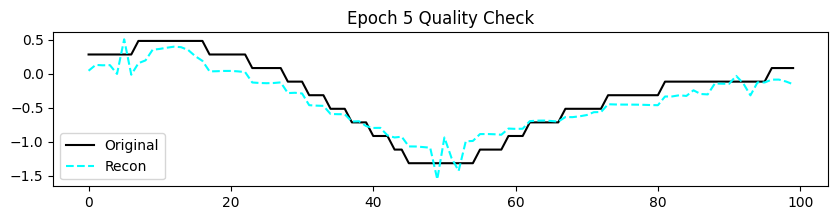

Epoch 6/50: Loss G=0.2849 | Loss D=1.1111
Epoch 7/50: Loss G=0.2521 | Loss D=1.2170
Epoch 8/50: Loss G=0.2230 | Loss D=1.3369
Epoch 9/50: Loss G=0.1957 | Loss D=1.4151
Epoch 10/50: Loss G=0.1726 | Loss D=1.4313


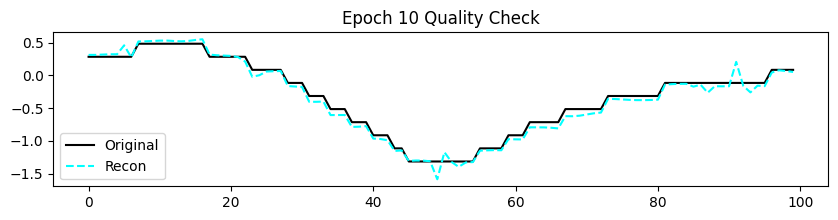

Epoch 11/50: Loss G=0.1528 | Loss D=1.4278
Epoch 12/50: Loss G=0.1345 | Loss D=1.4149
Epoch 13/50: Loss G=0.1184 | Loss D=1.3992
Epoch 14/50: Loss G=0.1058 | Loss D=1.3991
Epoch 15/50: Loss G=0.0972 | Loss D=1.3830


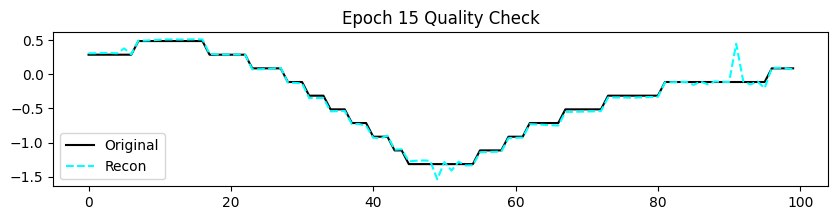

Epoch 16/50: Loss G=0.0875 | Loss D=1.3720
Epoch 17/50: Loss G=0.0818 | Loss D=1.3757
Epoch 18/50: Loss G=0.0751 | Loss D=1.3713
Epoch 19/50: Loss G=0.0725 | Loss D=1.3644
Epoch 20/50: Loss G=0.0669 | Loss D=1.3631


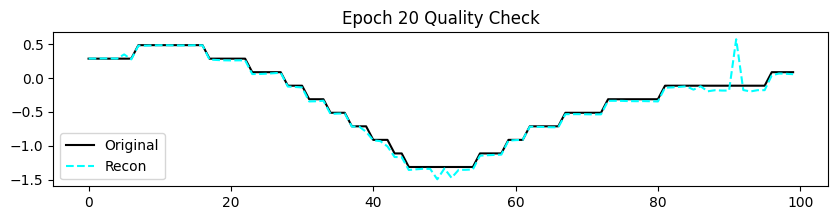

Epoch 21/50: Loss G=0.0664 | Loss D=1.3745
Epoch 22/50: Loss G=0.0628 | Loss D=1.3779
Epoch 23/50: Loss G=0.0609 | Loss D=1.3763
Epoch 24/50: Loss G=0.0586 | Loss D=1.3728
Epoch 25/50: Loss G=0.0574 | Loss D=1.3761


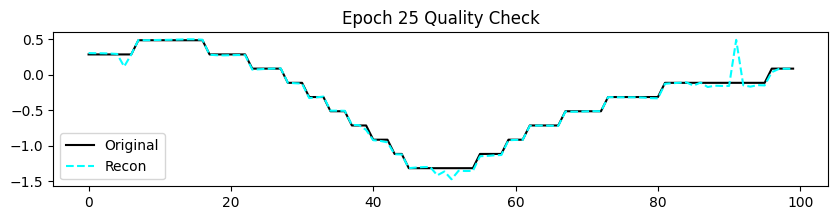

Epoch 26/50: Loss G=0.0556 | Loss D=1.3759
Epoch 27/50: Loss G=0.0541 | Loss D=1.3703
Epoch 28/50: Loss G=0.0535 | Loss D=1.3691
Epoch 29/50: Loss G=0.0521 | Loss D=1.3698
Epoch 30/50: Loss G=0.0503 | Loss D=1.3713


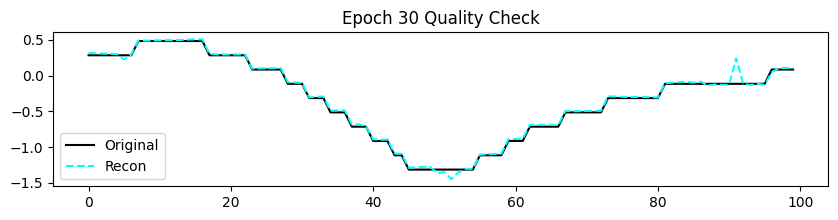

Epoch 31/50: Loss G=0.0498 | Loss D=1.3729
Epoch 32/50: Loss G=0.0498 | Loss D=1.3695
Epoch 33/50: Loss G=0.0486 | Loss D=1.3719
Epoch 34/50: Loss G=0.0476 | Loss D=1.3741
Epoch 35/50: Loss G=0.0474 | Loss D=1.3752


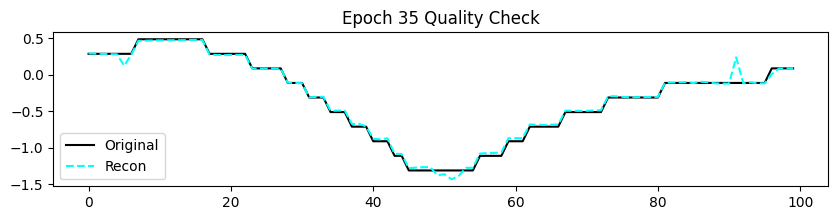

Epoch 36/50: Loss G=0.0457 | Loss D=1.3754
Epoch 37/50: Loss G=0.0459 | Loss D=1.3754
Epoch 38/50: Loss G=0.0442 | Loss D=1.3702
Epoch 39/50: Loss G=0.0452 | Loss D=1.3788
Epoch 40/50: Loss G=0.0437 | Loss D=1.3873


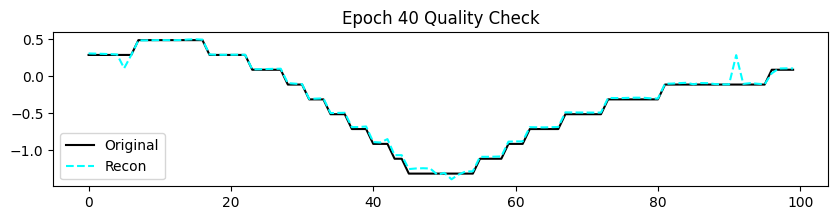

Epoch 41/50: Loss G=0.0443 | Loss D=1.3776
Epoch 42/50: Loss G=0.0438 | Loss D=1.3743
Epoch 43/50: Loss G=0.0435 | Loss D=1.3800
Epoch 44/50: Loss G=0.0427 | Loss D=1.3817
Epoch 45/50: Loss G=0.0432 | Loss D=1.3785


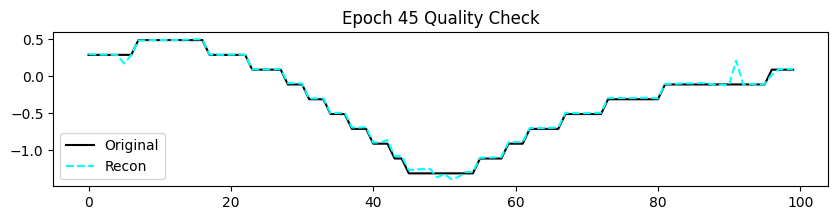

Epoch 46/50: Loss G=0.0415 | Loss D=1.3744
Epoch 47/50: Loss G=0.0424 | Loss D=1.3795
Epoch 48/50: Loss G=0.0422 | Loss D=1.3784
Epoch 49/50: Loss G=0.0418 | Loss D=1.3762
Epoch 50/50: Loss G=0.0410 | Loss D=1.3761


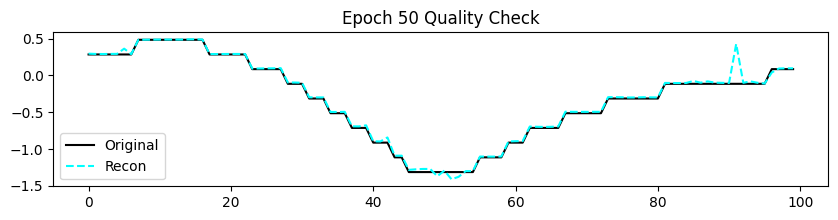

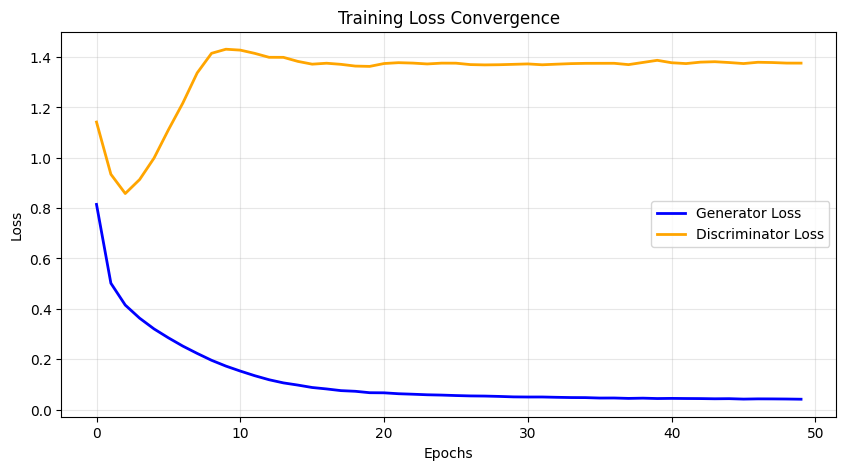

In [36]:
# --- CELL 3: Full Framework Training (Clean Plotting + Variable Return) ---
import matplotlib.pyplot as plt
import torch.nn.functional as F

def info_nce_loss(z1, z2, temperature=0.5):
    """Contrastive Loss for representation learning."""
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    logits = torch.matmul(z1, z2.T) / temperature
    labels = torch.arange(z1.size(0)).to(z1.device)
    return F.cross_entropy(logits, labels)

def train_final_model(epochs=20):
    # Initialize Models
    model = TransformerGAN(feat_dim).to(DEVICE)
    disc = Discriminator(feat_dim, 100).to(DEVICE)
    
    opt_g = torch.optim.Adam(model.parameters(), lr=1e-4)
    opt_d = torch.optim.Adam(disc.parameters(), lr=1e-4)
    
    # History for plotting
    history = {'g_loss': [], 'd_loss': []}

    # Sample for intermediate visualization (Quality Check)
    sample_batch = next(iter(train_loader))
    fixed_sample = sample_batch[2][0:1].to(DEVICE)
    
    print("Starting Full Framework Training...")
    
    for ep in range(epochs):
        model.train()
        epoch_g_loss = 0
        epoch_d_loss = 0
        
        for v1, v2, real in train_loader:
            v1, v2, real = v1.to(DEVICE), v2.to(DEVICE), real.to(DEVICE)
            
            # --- Train Generator ---
            opt_g.zero_grad()
            
            recon1, z1 = model(v1)
            recon2, z2 = model(v2)
            
            # 1. Reconstruction Loss
            l_rec = F.mse_loss(recon1, real) + F.mse_loss(recon2, real)
            
            # 2. Contrastive Loss
            l_cont = info_nce_loss(z1, z2)
            
            # 3. Adversarial Loss
            fake_pred = disc(recon1)
            l_adv = F.binary_cross_entropy(fake_pred, torch.ones_like(fake_pred))
            
            # Combined Loss (Weighted)
            loss_g = l_rec + 0.01 * l_cont + 0.005 * l_adv
            
            loss_g.backward()
            opt_g.step()
            
            # --- Train Discriminator ---
            opt_d.zero_grad()
            d_real = disc(real)
            d_fake = disc(recon1.detach())
            l_d = F.binary_cross_entropy(d_real, torch.ones_like(d_real)) + \
                  F.binary_cross_entropy(d_fake, torch.zeros_like(d_fake))
            l_d.backward()
            opt_d.step()
            
            epoch_g_loss += loss_g.item()
            epoch_d_loss += l_d.item()
            
        # Averages
        avg_g = epoch_g_loss / len(train_loader)
        avg_d = epoch_d_loss / len(train_loader)
        history['g_loss'].append(avg_g)
        history['d_loss'].append(avg_d)
        
        print(f"Epoch {ep+1}/{epochs}: Loss G={avg_g:.4f} | Loss D={avg_d:.4f}")
        if (ep+1) % 5 == 0:
            model.eval()
            with torch.no_grad():
                rec, _ = model(fixed_sample)
                orig = fixed_sample.cpu().numpy().squeeze()
                pred = rec.cpu().numpy().squeeze()
                
                plt.figure(figsize=(10, 2))
                plt.plot(orig[:, 0], label='Original', color='black')
                plt.plot(pred[:, 0], label='Recon', color='cyan', linestyle='--')
                plt.title(f"Epoch {ep+1} Quality Check")
                plt.legend()
                plt.show()
        
    # --- FINAL LOSS GRAPH ---
    plt.figure(figsize=(10, 5))
    plt.plot(history['g_loss'], label='Generator Loss', color='blue', linewidth=2)
    plt.plot(history['d_loss'], label='Discriminator Loss', color='orange', linewidth=2)
    plt.title("Training Loss Convergence")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
                
    return model

# Run it
model = train_final_model(epochs=50)

Evaluating...


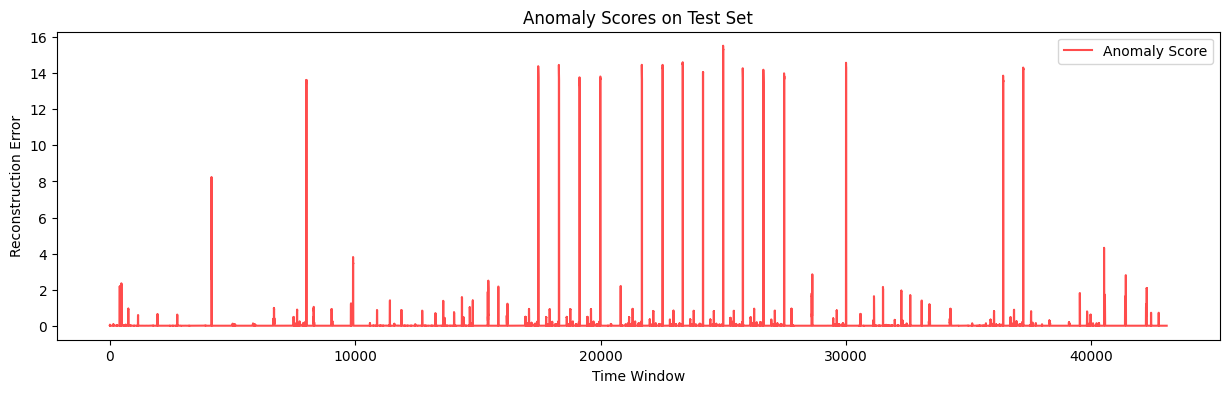

Evaluation Complete.
   Max Score: 15.5261
   Min Score: 0.0000
   Mean Score: 0.0804


In [37]:
# --- CELL 4: Evaluation ---
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score

def evaluate():
    print("Evaluating...")
    model.eval()
    scores = []
    
    with torch.no_grad():
        for x in test_loader:
            x = x.to(DEVICE)
            recon, _ = model(x)
            # MSE Error per window
            err = torch.mean((x - recon) ** 2, dim=[1, 2])
            scores.extend(err.cpu().numpy())
    
    scores = np.array(scores)
    
    # Visualization of Scores
    plt.figure(figsize=(15, 4))
    plt.plot(scores, label='Anomaly Score', color='red', alpha=0.7)
    plt.title("Anomaly Scores on Test Set")
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Time Window")
    plt.legend()
    plt.show()
    
    print("Evaluation Complete.")
    print(f"   Max Score: {scores.max():.4f}")
    print(f"   Min Score: {scores.min():.4f}")
    print(f"   Mean Score: {scores.mean():.4f}")

evaluate()

Evaluating...
Evaluation Complete.
   Total Windows: 43076
   Max Score: 15.5261


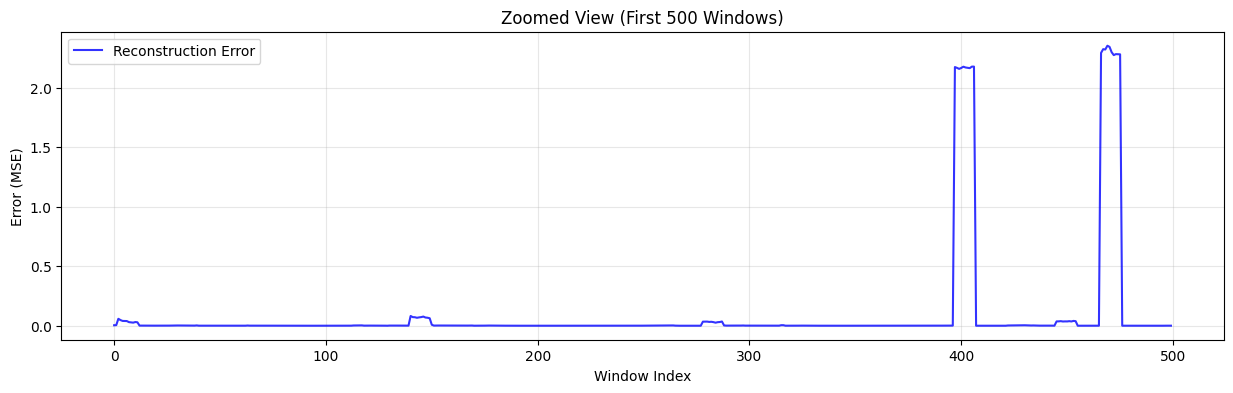

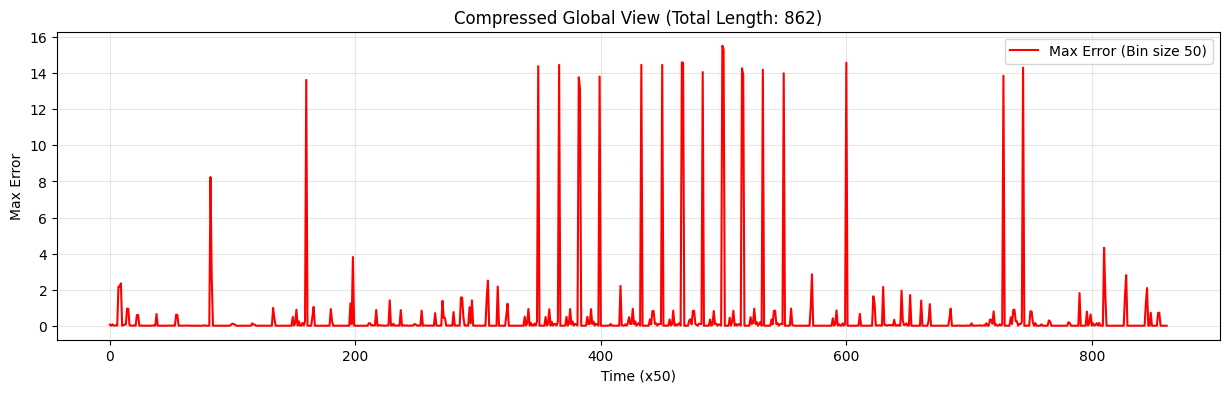

In [38]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def evaluate_visual(subset_size=1000, bin_size=10):
    print("Evaluating...")
    model.eval()
    scores = []
    
    with torch.no_grad():
        for x in test_loader:
            x = x.to(DEVICE)
            recon, _ = model(x)
            # MSE Error per window
            err = torch.mean((x - recon) ** 2, dim=[1, 2])
            scores.extend(err.cpu().numpy())
            
    scores = np.array(scores)
    
    print("Evaluation Complete.")
    print(f"   Total Windows: {len(scores)}")
    print(f"   Max Score: {scores.max():.4f}")
    
    # --- PLOT 1: Zoomed-In Slice (Detailed View) ---
    # Shows the first 'subset_size' points only
    plt.figure(figsize=(15, 4))
    plt.plot(scores[:subset_size], label='Reconstruction Error', color='blue', alpha=0.8)
    plt.title(f"Zoomed View (First {subset_size} Windows)")
    plt.ylabel("Error (MSE)")
    plt.xlabel("Window Index")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    
    
    # Pad to make divisible by bin_size
    pad_len = (bin_size - len(scores) % bin_size) % bin_size
    padded_scores = np.pad(scores, (0, pad_len), constant_values=0)
    
    # Reshape and take Max
    downsampled = padded_scores.reshape(-1, bin_size).max(axis=1)
    
    plt.figure(figsize=(15, 4))
    plt.plot(downsampled, label=f'Max Error (Bin size {bin_size})', color='red')
    plt.title(f"Compressed Global View (Total Length: {len(downsampled)})")
    plt.ylabel("Max Error")
    plt.xlabel(f"Time (x{bin_size})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Run it
evaluate_visual(subset_size=500, bin_size=50)

Starting Comprehensive Synthetic Evaluation...
 Calculating Point Adjustment F1

FINAL RESULTS (Synthetic Data)
 AUPRC Score:       0.5794
 Best Standard F1:  0.5684  (Thresh: 0.0036)
 Best PA F1 Score:  0.5838  (Thresh: 1.9304)
Samples Evaluated: 43076
Anomalies Injected: 8669


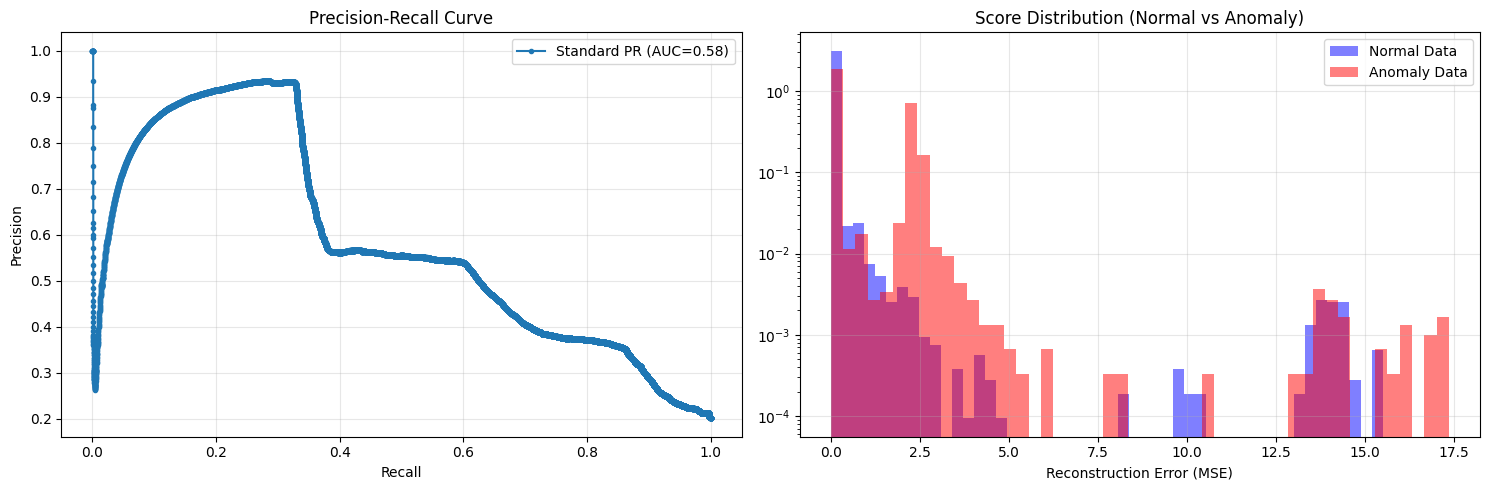

In [39]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

def apply_point_adjustment(pred, label):
   
    # Create a copy to avoid modifying original array
    adjusted_pred = pred.copy()
    
    # Find start and end indices of anomaly segments in Ground Truth
    # We pad with 0 to handle edge cases where anomaly starts at 0 or ends at len-1
    diff = np.diff(np.concatenate(([0], label, [0])))
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    
    # Iterate over each anomaly segment
    for start, end in zip(starts, ends):
        # If any point in this segment is predicted as 1
        if np.sum(adjusted_pred[start:end]) > 0:
            # Mark the whole segment as 1
            adjusted_pred[start:end] = 1
            
    return adjusted_pred

def evaluate_comprehensive_metrics(model, loader):
    print("Starting Comprehensive Synthetic Evaluation...")
    model.eval()
    
    y_true = []
    y_scores = []
    
    # --- 1. Generate Data & Scores ---
    for batch in loader:
        clean_windows = batch.cpu().numpy()
        corrupted_windows = []
        batch_labels = []
        
        for i in range(len(clean_windows)):
            # NOTE: Assumes inject_synthetic_anomalies is defined from previous cell
            c_win, lbl = inject_synthetic_anomalies(clean_windows[i])
            corrupted_windows.append(c_win)
            batch_labels.append(lbl)
            
        corrupted_tensor = torch.FloatTensor(np.array(corrupted_windows)).to(DEVICE)
        
        with torch.no_grad():
            recon, _ = model(corrupted_tensor)
            # MSE Error per window (Batch, Time, Feat) -> (Batch)
            error = torch.mean((corrupted_tensor - recon) ** 2, dim=[1, 2])
            
            y_scores.extend(error.cpu().numpy())
            y_true.extend(batch_labels)
            
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # --- 2. Calculate AUPRC (Threshold Independent) ---
    auprc = average_precision_score(y_true, y_scores)
    
    # --- 3. Calculate Best Standard F1 ---
    prec, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (prec * recall) / (prec + recall + 1e-6)
    
    best_f1 = np.max(f1_scores)
    best_thresh = thresholds[np.argmax(f1_scores)]
    
    # --- 4. Calculate Best PA F1 (Optimized) ---
    print(" Calculating Point Adjustment F1")
    
    # We search 100 thresholds between min and max score
    search_thresholds = np.linspace(np.min(y_scores), np.max(y_scores), 100)
    best_pa_f1 = 0
    best_pa_thresh = 0
    
    for th in search_thresholds:
        # 1. Binarize predictions
        pred_bin = (y_scores > th).astype(int)
        
        # 2. Apply Point Adjustment (If any anomaly point detected, fill segment)
        # Only apply if we actually predicted something, otherwise skip
        if np.sum(pred_bin) > 0:
            pred_pa = apply_point_adjustment(pred_bin, y_true)
            pa_f1 = f1_score(y_true, pred_pa)
            
            if pa_f1 > best_pa_f1:
                best_pa_f1 = pa_f1
                best_pa_thresh = th

    # --- 5. Report Results ---
    print(f"\n========================================")
    print(f"FINAL RESULTS (Synthetic Data)")
    print(f"========================================")
    print(f" AUPRC Score:       {auprc:.4f}")
    print(f" Best Standard F1:  {best_f1:.4f}  (Thresh: {best_thresh:.4f})")
    print(f" Best PA F1 Score:  {best_pa_f1:.4f}  (Thresh: {best_pa_thresh:.4f})")
    print(f"========================================")
    print(f"Samples Evaluated: {len(y_true)}")
    print(f"Anomalies Injected: {int(sum(y_true))}")
    
    # --- 6. Visualizations ---
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Precision-Recall Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, prec, marker='.', label=f'Standard PR (AUC={auprc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Score Distribution (The most important debug plot)
    plt.subplot(1, 2, 2)
    # Normalize histograms to see overlap clearly
    plt.hist(y_scores[y_true==0], bins=50, alpha=0.5, label='Normal Data', density=True, color='blue')
    plt.hist(y_scores[y_true==1], bins=50, alpha=0.5, label='Anomaly Data', density=True, color='red')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.title('Score Distribution (Normal vs Anomaly)')
    plt.legend()
    plt.yscale('log') # Log scale helps see small outlier counts
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run Evaluation
evaluate_comprehensive_metrics(model, test_loader)